In [1]:
from datetime import datetime as dt
import os
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import seaborn as sns
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

def load_tree( loc, schema="nexus" ):
    """ Dendropy is dreadful for parsing comments from MCC trees. This function acts as a wrapper around
    Dendropy.Tree.get which uses baltics comment parsing algorithm. H/T to @evogytis.
    Parameters
    ----------
    loc : str
        location of MCC tree.
    schema : str
        format of MCC tree. Almost always nexus.
    Returns
    -------
    Dendropy.Tree
        Tree with commented values converted to annotations.
    """
    tree = Tree.get( path=loc, schema=schema, extract_comment_metadata=False, preserve_underscores=True )
    tree.label = os.path.basename( loc ).split( "_" )[1]
    for i in tree:
        if len( i.comments ) > 1:
            print( "Node has more than one comment" )
        comment = i.comments[0]
        numerics = re.findall( '[,&][A-Za-z\_\.0-9]+=[0-9\-Ee\.]+', comment ) ## find all entries that have values as floats
        strings = re.findall( '[,&][A-Za-z\_\.0-9]+=["|\']*[A-Za-z\_0-9\.\+ :\/\(\)\&\-]+[\"|\']*', comment ) ## strings
        sets = re.findall( '[,&][A-Za-z\_\.0-9\%]+={[A-Za-z\.\-0-9eE,\"\_ :\/\(\)\&]+}', comment )

        for vals in strings:
            tr, val = vals.split( '=' )
            tr = tr[1:]
            if '+' in val:
                val = val.split( '+' )[0] ## DO NOT ALLOW EQUIPROBABLE DOUBLE ANNOTATIONS (which are in format "A+B") - just get the first one
            i.annotations[tr] = val.strip( '"' )

        for vals in numerics: ## assign all parsed annotations to traits of current branch
            tr, val=vals.split( '=' ) ## split each value by =, left side is name, right side is value
            tr = tr[1:]
            if val.replace( 'E', '', 1 ).replace( 'e', '', 1 ).replace( '-', '', 1 ).replace( '.', '', 1 ).isdigit():
                i.annotations[tr] = float( val )

        for vals in sets:
            tr, val = vals.split( '=' )
            tr = tr[1:]
            if 'set' in tr:
                i.annotations[tr] = list()
                for v in val[1:-1].split( ',' ):
                    if 'set.prob' in tr:
                        i.annotations[tr].value.append( float( v ) )
                    else:
                        i.annotations[tr].value.append( v.strip( '"' ) )
            else:
                try:
                    i.annotations[tr] = list( map( float, val[1:-1].split( ',' ) ) )
                except Exception:
                    print( 'some other trait: %s' % vals )
    return tree

def get_children( node, field ):
    return_list = []
    location = node.annotations.get_value( field )
    for i in node.child_node_iter( lambda x: x.annotations.get_value( field ) == location ):
        if i.is_leaf():
            return_list.append( i )
        else:
            return_list.extend( get_children( i, field ) )
    return return_list

def get_posterior( node ):
    if node.taxon is not None:
        return 1.0
    else:
        value = node.annotations["posterior"].value
        return float( value )

def get_ancestral_state( node, threshold, field ):
    for i in node.ancestor_iter():
        if get_posterior( i ) > threshold:
            return i.annotations[field].value
    print( "No supported nodes above... Might be root" )
    
def get_introductions( tree, field, interest, threshold=0.5, mrsd=0 ):
    return_list = list()
    def _identity_func( node ):
        if node.parent_node is None:
            return False
        if get_posterior( node ) < threshold:
            return False
        return (node.annotations.get_value( field ) == interest) & (get_ancestral_state( node, threshold, field ) != interest)
    
    for i in tree.preorder_node_iter( filter_fn=_identity_func ):
        node_dict = i.annotations.values_as_dict()
        node_dict[f"par.{field}"] = get_ancestral_state( i, threshold, field )
        node_dict[f"par.{field}.prob"] = get_ancestral_state( i, threshold, f"{field}.prob" )
        node_dict[f"par.{field}.set"] = get_ancestral_state( i, threshold, f"{field}.set" )
        node_dict[f"par.{field}.set.prob"] = get_ancestral_state( i, threshold, f"{field}.set.prob" )
        
        children = get_children( i, field )
        children_dates = [float( child.annotations["height"].value ) for child in children]
        node_dict["children"] = len( children )
        node_dict["children.names"] = [child.taxon.label for child in children]
        if len( children ) > 0:
            node_dict["earliest_date"] = max( children_dates )
            node_dict["latest_date"] = min( children_dates )
        #node_dict["temp.names"] = [child.taxon.label for child in i.leaf_iter()]
        #node_dict["children.dates"] = [float( child.annotations["height"].value ) for child in children]
        return_list.append( node_dict )
    return_df = pd.DataFrame( return_list )
    return_df["height"] = mrsd - return_df["height"]
    return_df["earliest_date"] = mrsd - return_df["earliest_date"]
    return_df["latest_date"] = mrsd - return_df["latest_date"]
    return_df["delay"] = return_df["earliest_date"] - return_df["height"] 
    return_df["lineage_length"] = return_df["latest_date"] - return_df["height"]
    #return_df["Date"] = return_df["height"].apply( dec_to_date )
    #return_df["Week"] = return_df["Date"].apply( lambda x: Week.fromdate(x).startdate() )
    #return_df["Week"] = return_df["Week"]
    return pd.DataFrame( return_df )

In [2]:
t = load_tree( "../data/2021-08-30_fixed_eponential_discrete.mcc.tree", schema="nexus" )

recent_date = _toYearFraction( max( [i.label.split( "|" )[-1] for i in t.taxon_namespace] )[-20:] )

In [3]:
df = get_introductions(t, "Location", "San Diego", threshold=0.5, mrsd=recent_date )
df["delay"] = df["delay"]*365
df["lineage_length"] = df["lineage_length"]*365
df.shape

(324, 27)

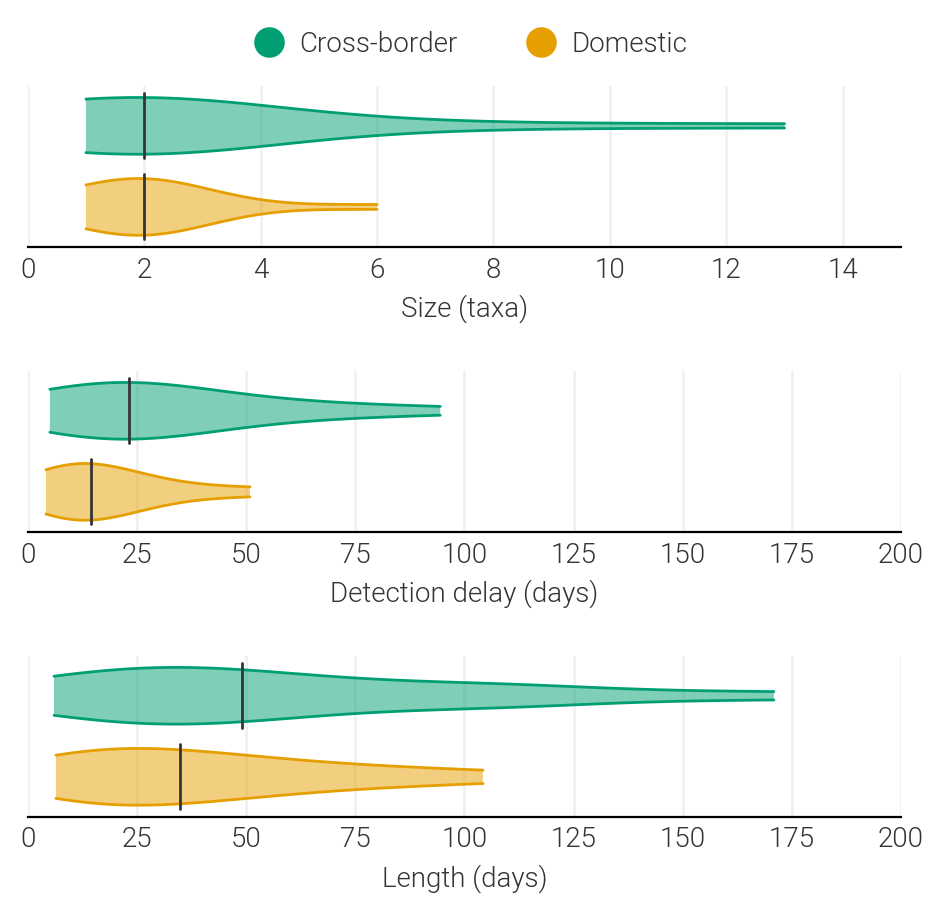

In [8]:
comparisons = [
    (df["par.Location"].isin(["Los Angeles", "United States"]))&(df["children"]>0),
    (df["par.Location"].isin(["Baja California", "Mexico"]))&(df["children"]>0),
]

colors = [
    "#E69F00",
    "#009E73",
]

column_names = [
    "Size (taxa)",
    "Detection delay (days)",
    "Length (days)"
]

fig, ax = plt.subplots( dpi=200, figsize=(5,5), nrows=3 )
for i, query in enumerate( comparisons ):
    for row, value in enumerate( ["children", "delay", "lineage_length"] ):
        data = df.loc[query, value].to_numpy().ravel()
        data = data[~np.isnan(data)]
        data_median = np.median( data )

        hpdHi, hpdLo = hpd( data, 0.95 )
        x_grid = np.linspace( hpdLo, hpdHi, 101 )

        kde = gaussian_kde( data )
        y_grid = kde.evaluate( x_grid )
        y_grid = y_grid / y_grid.max() * 0.35

        ax[row].plot(x_grid, [i+y for y in y_grid], color=colors[i], lw=1, zorder=100, solid_capstyle="round" )
        ax[row].plot(x_grid, [i-y for y in y_grid], color=colors[i], lw=1, zorder=100, solid_capstyle="round" )

        ax[row].fill_between( x_grid, [i-y for y in y_grid], [i+y for y in y_grid], facecolor=colors[i], edgecolor='none', alpha=0.5, zorder=100 )
        ln = ax[row].vlines( x=data_median, ymin=i-0.4, ymax=i+0.4, color=COLOR, linewidth=1, zorder=110 )
        ln.set_capstyle( "round" )

for row, _ in enumerate( ["children", "delay", "lineage_length"] ):
    ax[row].set_yticks( [] )
    #ax[row].set_yticklabels( [
    #    "Baja California",
    #    "Los Angeles"
    #] )

    basic_formatting( ax[row], xlabel=column_names[row], which="x", xsize=10 )
    ax[row].tick_params( axis="x", bottom=False, which="both", rotation=0, pad=0 )

ax[0].set_xlim( 0, 15 )
ax[0].xaxis.get_major_locator().set_params(integer=True)
ax[1].set_xlim( 0, 200 )
ax[2].set_xlim( 0, 200 )

legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Cross-border", markersize=10 ),
          Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="Domestic", markersize=10 )]
ax[0].legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=10, ncol=2,
          bbox_to_anchor=(0,0,1,1.5) )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_cross-border-transmission-lineages-dynamics.pdf" )
plt.show()

In [9]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

sig_test = {
    "trait" : [],
    "pvalue" : []
}

for trait in ["children", "delay", "lineage_length"]:
    try:
        result = mannwhitneyu( df.loc[comparisons[0],trait].dropna(), df.loc[comparisons[1],trait].dropna())
    except ValueError as err:
        print( err )
        continue
    sig_test["trait"].append( trait )
    sig_test["pvalue"].append( result.pvalue )
sig_test = pd.DataFrame( sig_test )
sig_test = sig_test.dropna()
results = multipletests( sig_test["pvalue"], alpha=0.05, method="fdr_bh" )
sig_test["corrected"] = results[1]
sig_test["reject_h0"] = results[0]
sig_test

,trait,pvalue,corrected,reject_h0
0,children,0.930712,0.930712,False
1,delay,0.011954,0.035863,True
2,lineage_length,0.150220,0.225331,False
